# compare mel vs star

In [1]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *
from utils import *
from scipy.spatial import distance
import seaborn as sns
import umap
from itertools import combinations, product

In [2]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [3]:
morph_folder = os.path.abspath('/mnt/cube/kai/repositories/morphs/data/stimuli')
results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/morph')

# load all dfs

In [92]:
group_pred_star = pickle.load(open(os.path.join(results_folder, 'norm_robust', 'all_predicted.p'), 'rb'))
group_pred_star['scale'] = 'star'
group_pred_mel = pickle.load(open(os.path.join(results_folder, 'norm_robust_mel', 'all_predicted.p'), 'rb'))
group_pred_mel['scale'] = 'mel'
group1_behav = pickle.load(open(os.path.join(results_folder, 'group1_behav.p'), 'rb'))
group2_behav = pickle.load(open(os.path.join(results_folder, 'group2_behav.p'), 'rb'))
group3_behav = pickle.load(open(os.path.join(results_folder, 'group3_behav.p'), 'rb'))

In [93]:
all_groups = pd.concat([group_pred_star, group_pred_mel,
                       group1_behav, group2_behav, group3_behav]).reset_index(drop=True)

In [94]:
all_groups.tail()

,index,min_val,max_val,slope,inflection,group,metric,scale,subj
402,df,0.018225,0.951094,0.202028,48.683433,Group 3,behav,NaN,B1101
403,fg,0.086618,0.913664,1.151891,78.842110,Group 3,behav,NaN,B1222
404,fg,0.047706,0.976152,0.275545,76.420456,Group 3,behav,NaN,B1101
405,fh,0.066304,0.916032,0.231404,67.285280,Group 3,behav,NaN,B1222
406,fh,0.052882,0.980467,0.158747,74.250978,Group 3,behav,NaN,B1101


In [95]:
all_groups= all_groups.drop(all_groups[all_groups.metric=='frmse'].index).reset_index(drop=True)

In [96]:
all_groups.scale.fillna('behav', inplace=True)

In [97]:
all_groups.metric.unique()

array(['rmse', 'fcosine', 'behav'], dtype=object)

In [98]:
def get_formal_metric(x):
    if x['metric'] == 'fcosine':
        if x['scale']=='star':
            return 'Star'
        else:
            return 'Mel'
    elif x['metric'] == 'rmse':
        return 'MSE'
    else:
        return 'Ground Truth'

In [99]:
all_groups['metric_formal'] = all_groups.apply(get_formal_metric, axis=1)

In [100]:
all_groups.head()

,index,min_val,max_val,slope,inflection,group,metric,scale,subj,metric_formal
0,ae,1.000000e-16,1.000000,0.033214,75.202742,Group 1,rmse,star,NaN,MSE
1,af,1.000000e-16,0.945304,0.032496,84.500302,Group 1,rmse,star,NaN,MSE
2,ag,1.000000e-16,0.860692,0.037051,76.503340,Group 1,rmse,star,NaN,MSE
3,ah,1.000000e-16,0.616709,0.065078,56.980419,Group 1,rmse,star,NaN,MSE
4,be,7.801580e-03,0.904488,0.054682,84.002627,Group 1,rmse,star,NaN,MSE


In [101]:
all_groups.drop(all_groups[all_groups['slope'] > 1].index, inplace = True)

(0.0, 1.0)

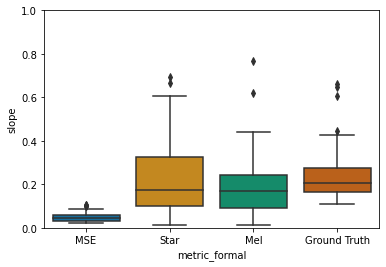

In [102]:
ax = sns.boxplot(y='slope', x='metric_formal',data=all_groups)
ax.set_ylim([0,1])

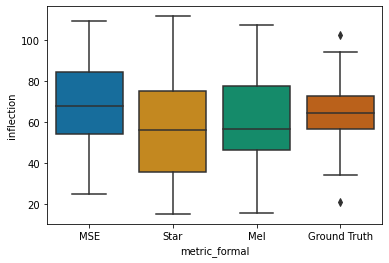

In [103]:
ax = sns.boxplot(y='inflection', x='metric_formal',data=all_groups)

In [104]:
import statsmodels.formula.api as smf

In [105]:
all_groups.subj.fillna(all_groups.metric_formal, inplace=True)

In [106]:
all_groups.tail()

,index,min_val,max_val,slope,inflection,group,metric,scale,subj,metric_formal
308,df,0.071990,0.935135,0.157202,59.400512,Group 3,behav,behav,B1222,Ground Truth
309,df,0.018225,0.951094,0.202028,48.683433,Group 3,behav,behav,B1101,Ground Truth
311,fg,0.047706,0.976152,0.275545,76.420456,Group 3,behav,behav,B1101,Ground Truth
312,fh,0.066304,0.916032,0.231404,67.285280,Group 3,behav,behav,B1222,Ground Truth
313,fh,0.052882,0.980467,0.158747,74.250978,Group 3,behav,behav,B1101,Ground Truth


In [107]:
all_groups['stim'] = all_groups['index']
all_groups.drop(columns=['index'], inplace=True)

In [108]:
model = smf.mixedlm("slope ~ C(metric_formal, Treatment('Ground Truth')) ",
                    all_groups,
                    groups= "stim").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
===============================================================================================
Model:                           MixedLM              Dependent Variable:              slope   
No. Observations:                303                  Method:                          REML    
No. Groups:                      24                   Scale:                           0.0110  
Min. group size:                 9                    Log-Likelihood:                  234.3889
Max. group size:                 14                   Converged:                       Yes     
Mean group size:                 12.6                                                          
-----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                            0.230    0.011  21.002 0.000  0.208  0.251
C(metric_formal, Treatment('Ground Truth'))[T.MSE]  -0.180    0.014 -12.558 0.000 -0.208 -0.152
C(metric_formal, Treatment('Ground Truth'))[T.Mel]  -0.027    0.020  -1.383 0.167 -0.065  0.011
C(metric_formal, Treatment('Ground Truth'))[T.Star]  0.001    0.018   0.042 0.966 -0.035  0.036
stim Var                                             0.001    0.005                            
===============================================================================================

"""

In [109]:
model = smf.mixedlm("slope ~ C(metric_formal, Treatment('Ground Truth')) ",
                    all_groups,
                    groups= "group").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
===============================================================================================
Model:                           MixedLM              Dependent Variable:              slope   
No. Observations:                303                  Method:                          REML    
No. Groups:                      3                    Scale:                           0.0117  
Min. group size:                 89                   Log-Likelihood:                  232.0478
Max. group size:                 124                  Converged:                       Yes     
Mean group size:                 101.0                                                         
-----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                            0.231    0.010  22.814 0.000  0.211  0.250
C(metric_formal, Treatment('Ground Truth'))[T.MSE]  -0.181    0.015 -12.243 0.000 -0.210 -0.152
C(metric_formal, Treatment('Ground Truth'))[T.Mel]  -0.030    0.020  -1.495 0.135 -0.069  0.009
C(metric_formal, Treatment('Ground Truth'))[T.Star] -0.000    0.019  -0.022 0.983 -0.037  0.036
group Var                                            0.000    0.001                            
===============================================================================================

"""

In [110]:
model = smf.mixedlm("inflection ~ C(metric_formal, Treatment('Ground Truth'))",
                    all_groups,
                    groups= "stim").fit()

model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
================================================================================================
Model:                          MixedLM              Dependent Variable:              inflection
No. Observations:               303                  Method:                          REML      
No. Groups:                     24                   Scale:                           258.8593  
Min. group size:                9                    Log-Likelihood:                  -1285.4283
Max. group size:                14                   Converged:                       Yes       
Mean group size:                12.6                                                            
------------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------------------------
Intercept                                            63.245    2.662 23.758 0.000  58.027 68.462
C(metric_formal, Treatment('Ground Truth'))[T.MSE]    5.331    2.203  2.420 0.016   1.013  9.650
C(metric_formal, Treatment('Ground Truth'))[T.Mel]   -4.332    3.002 -1.443 0.149 -10.216  1.551
C(metric_formal, Treatment('Ground Truth'))[T.Star]  -5.029    2.801 -1.795 0.073 -10.520  0.461
stim Var                                            120.432    2.691                            
================================================================================================

"""

In [111]:
model = smf.mixedlm("inflection ~ C(metric_formal, Treatment('Ground Truth'))",
                    all_groups,
                    groups= "group").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
===============================================================================================
Model:                         MixedLM              Dependent Variable:              inflection
No. Observations:              303                  Method:                          REML      
No. Groups:                    3                    Scale:                           376.2539  
Min. group size:               89                   Log-Likelihood:                  -1319.2972
Max. group size:               124                  Converged:                       Yes       
Mean group size:               101.0                                                           
-----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                           63.615    1.742 36.519 0.000  60.201 67.029
C(metric_formal, Treatment('Ground Truth'))[T.MSE]   5.093    2.649  1.923 0.054  -0.098 10.284
C(metric_formal, Treatment('Ground Truth'))[T.Mel]  -4.021    3.586 -1.121 0.262 -11.050  3.008
C(metric_formal, Treatment('Ground Truth'))[T.Star] -5.077    3.366 -1.508 0.132 -11.674  1.521
group Var                                            0.195                                     
===============================================================================================

"""

In [112]:
all_groups

,min_val,max_val,slope,inflection,group,metric,scale,subj,metric_formal,stim
0,1.000000e-16,1.000000,0.033214,75.202742,Group 1,rmse,star,MSE,MSE,ae
1,1.000000e-16,0.945304,0.032496,84.500302,Group 1,rmse,star,MSE,MSE,af
2,1.000000e-16,0.860692,0.037051,76.503340,Group 1,rmse,star,MSE,MSE,ag
3,1.000000e-16,0.616709,0.065078,56.980419,Group 1,rmse,star,MSE,MSE,ah
4,7.801580e-03,0.904488,0.054682,84.002627,Group 1,rmse,star,MSE,MSE,be
...,...,...,...,...,...,...,...,...,...,...
308,7.199034e-02,0.935135,0.157202,59.400512,Group 3,behav,behav,B1222,Ground Truth,df
309,1.822476e-02,0.951094,0.202028,48.683433,Group 3,behav,behav,B1101,Ground Truth,df
311,4.770582e-02,0.976152,0.275545,76.420456,Group 3,behav,behav,B1101,Ground Truth,fg
312,6.630351e-02,0.916032,0.231404,67.285280,Group 3,behav,behav,B1222,Ground Truth,fh
